In [1]:
!pip install kaggle

In [2]:
!pip install numerapi    # ==2.3.8
import numerapi

In [3]:
!pip install xgboost    # ==1.3.0.post0

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import pathlib
from tqdm.auto import tqdm
import joblib
import json
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from multiprocessing import Pool, cpu_count
import time
import requests as re
from datetime import datetime
from dateutil.relativedelta import relativedelta, FR

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# visualize
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib_venn import venn2, venn3
import seaborn as sns
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter
sns.set_context("talk")
style.use('seaborn-colorblind')

import warnings
warnings.simplefilter('ignore')

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
today = datetime.now().strftime('%Y-%m-%d')
today

'2021-10-10'

In [6]:
# config class
class CFG:
    """
    Set FETCH_VIA_API = True if you want to fetch the data via API.
    Otherwise we use the daily-updated one in the kaggle dataset (faster).
    """
    INPUT_DIR = './content/drive/My Drive/signals/'
    OUTPUT_DIR = './content/drive/My Drive/signals/'
    FETCH_VIA_API = False
    SEED = 46
    DEBUG = False # True, test mode using small set of tickers

In [7]:
# Logging is always nice for your experiment:)
def init_logger(log_file='train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

#logger = init_logger(log_file=f'{CFG.OUTPUT_DIR}/{today}.log')
logger = init_logger(log_file=f'{today}.log')
logger.info('Start Logging...')

Start Logging...


In [8]:
napi = numerapi.SignalsAPI()
logger.info('numerai api setup!')

numerai api setup!
2021-10-10 09:30:02,837 INFO __main__: numerai api setup!


In [9]:
# read in list of active Signals tickers which can change slightly era to era
eligible_tickers = pd.Series(napi.ticker_universe(), name='ticker') 
logger.info(f"Number of eligible tickers: {len(eligible_tickers)}")

Number of eligible tickers: 5340
2021-10-10 09:30:03,713 INFO __main__: Number of eligible tickers: 5340


In [10]:
# read in yahoo to numerai ticker map, still a work in progress, h/t wsouza and 
# this tickermap is a work in progress and not guaranteed to be 100% correct
ticker_map = pd.read_csv('https://numerai-signals-public-data.s3-us-west-2.amazonaws.com/signals_ticker_map_w_bbg.csv')
ticker_map = ticker_map[ticker_map.bloomberg_ticker.isin(eligible_tickers)]

numerai_tickers = ticker_map['ticker']
yfinance_tickers = ticker_map['yahoo']
logger.info(f"Number of eligible tickers in map: {len(ticker_map)}")

Number of eligible tickers in map: 5340
2021-10-10 09:30:04,955 INFO __main__: Number of eligible tickers in map: 5340


In [11]:
print(ticker_map.shape)
ticker_map.head()

(5340, 3)


,ticker,bloomberg_ticker,yahoo
0,000060 KS,000060 KS,000060.KS
1,000080 KS,000080 KS,000080.KS
2,000100 KS,000100 KS,000100.KS
3,000120 KS,000120 KS,000120.KS
4,000210 KS,000210 KS,000210.KS


In [12]:
# If you want to fetch the data on your own, you can use this function...

def fetch_yfinance(ticker_map, start='2002-12-01'):
    """
    # fetch yfinance data
    :INPUT:
    - ticker_map : Numerai eligible ticker map (pd.DataFrame)
    - start : date (str)
    
    :OUTPUT:
    - full_data : pd.DataFrame ('date', 'ticker', 'close', 'raw_close', 'high', 'low', 'open', 'volume')
    """
    
    # ticker map
    numerai_tickers = ticker_map['ticker']
    yfinance_tickers = ticker_map['yahoo']

    # fetch
    raw_data = yfinance.download(
        yfinance_tickers.str.cat(sep=' '), 
        start=start, 
        threads=True
    ) 
    
    # format
    cols = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
    full_data = raw_data[cols].stack().reset_index()
    full_data.columns = ['date', 'ticker', 'close', 'raw_close', 'high', 'low', 'open', 'volume']
    
    # map yfiance ticker to numerai tickers
    full_data['ticker'] = full_data.ticker.map(
        dict(zip(yfinance_tickers, numerai_tickers))
    )
    return full_data

In [13]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd "/content/drive/My Drive/signals"
# import sys
# sys.path.append('/content/drive/My Drive/signals')

In [14]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it. ##
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [15]:
!kaggle datasets download -d code1110/yfinance-stock-price-data-for-numerai-signals

 94% 370M/394M [00:05<00:00, 34.2MB/s]
100% 394M/394M [00:05<00:00, 70.4MB/s]


In [16]:
%%time

if CFG.FETCH_VIA_API: # fetch data via api
    logger.info('Fetch data via API...may take some time...')
    !pip install yfinance    #==0.1.62
    !pip install simplejson
    import yfinance
    import simplejson
    
    df = fetch_yfinance(ticker_map, start='2002-12-01')
else: # loading from the kaggle dataset (https://www.kaggle.com/code1110/yfinance-stock-price-data-for-numerai-signals)
    logger.info('Load data from the kaggle dataset...')
    #df = pd.read_csv(pathlib.Path(f'{CFG.INPUT_DIR}/full_data.csv'))
    #df = pd.read_csv(pathlib.Path(f'full_data.csv'))
    df = pd.read_csv(r"../content/yfinance-stock-price-data-for-numerai-signals.zip")

print(df.shape)
df.head(3)

Load data from the kaggle dataset...
2021-10-10 09:30:24,019 INFO __main__: Load data from the kaggle dataset...


(18908242, 8)
CPU times: user 25.9 s, sys: 1.58 s, total: 27.5 s
Wall time: 27.4 s


In [17]:
df.tail(3)

,ticker,date,close,raw_close,high,low,open,volume
18908239,ZZZ.,2021-10-06,32.750000,32.750000,33.500000,32.560001,33.340000,39175.0
18908240,ZZZ.,2021-10-07,33.500000,33.500000,33.709999,32.860001,32.860001,57200.0
18908241,ZZZ.,2021-10-08,33.389999,33.389999,34.070000,33.290001,33.290001,72400.0


In [18]:
%%time

def read_numerai_signals_targets():
    # read in Signals targets
    # numerai_targets = 'https://numerai-signals-public-data.s3-us-west-2.amazonaws.com/signals_train_val.csv'
    numerai_targets = 'https://numerai-signals-public-data.s3-us-west-2.amazonaws.com/signals_train_val_bbg.csv'
    targets = pd.read_csv(numerai_targets)
    
    # to datetime int
    targets['friday_date'] = pd.to_datetime(targets['friday_date'].astype(str), format='%Y-%m-%d').dt.strftime('%Y%m%d').astype(int)
    
#     # train, valid split
#     train_targets = targets.query('data_type == "train"')
#     valid_targets = targets.query('data_type == "validation"')
    
    return targets

targets = read_numerai_signals_targets()

CPU times: user 24.3 s, sys: 592 ms, total: 24.9 s
Wall time: 34.1 s


In [19]:
# convert to numerai ticker, if the target ticker is not
if 'bloomberg_ticker' in targets.columns.values.tolist():
    targets['ticker'] = targets['bloomberg_ticker'].map(
        dict(zip(ticker_map['bloomberg_ticker'], ticker_map['ticker']))
    )
if 'bloomberg_ticker' not in targets.columns.values.tolist():
    targets['bloomberg_ticker'] = targets['ticker'].map(
        dict(zip(ticker_map['ticker'], ticker_map['bloomberg_ticker']))
    )
    
print(targets.shape, targets['friday_date'].min(), targets['friday_date'].max())
targets.head()

(4439859, 6) 20030131 20210924


,bloomberg_ticker,friday_date,data_type,target_4d,target_20d,ticker
0,000270 KS,20030131,train,0.50,0.50,000270 KS
1,000810 KS,20030131,train,0.50,0.50,000810 KS
2,000830 KS,20030131,train,0.50,0.50,NaN
3,002790 KS,20030131,train,0.25,0.25,002790 KS
4,003450 KS,20030131,train,0.25,0.50,NaN


In [20]:
targets.tail()

,bloomberg_ticker,friday_date,data_type,target_4d,target_20d,ticker
4439854,ZUMZ US,20210924,validation,0.50,NaN,ZUMZ
4439855,ZUO US,20210924,validation,0.50,NaN,ZUO
4439856,ZURN SW,20210924,validation,0.50,NaN,ZURN SW
4439857,ZYXI US,20210924,validation,0.25,NaN,ZYXI
4439858,ZZZ CN,20210924,validation,0.25,NaN,ZZZ.


2021-10-10 09:31:26,293 INFO numexpr.utils: NumExpr defaulting to 8 threads.
**************************************************
2021-10-10 09:31:26,589 INFO __main__: **************************************************
train target: 3,405 numerai tickers , 9,590 bloomberg tickers (friday_date: 20030131 - 20121228)
2021-10-10 09:31:26,814 INFO __main__: train target: 3,405 numerai tickers , 9,590 bloomberg tickers (friday_date: 20030131 - 20121228)
**************************************************
2021-10-10 09:31:27,079 INFO __main__: **************************************************
validation target: 5,315 numerai tickers , 9,687 bloomberg tickers (friday_date: 20130104 - 20210924)
2021-10-10 09:31:27,321 INFO __main__: validation target: 5,315 numerai tickers , 9,687 bloomberg tickers (friday_date: 20130104 - 20210924)


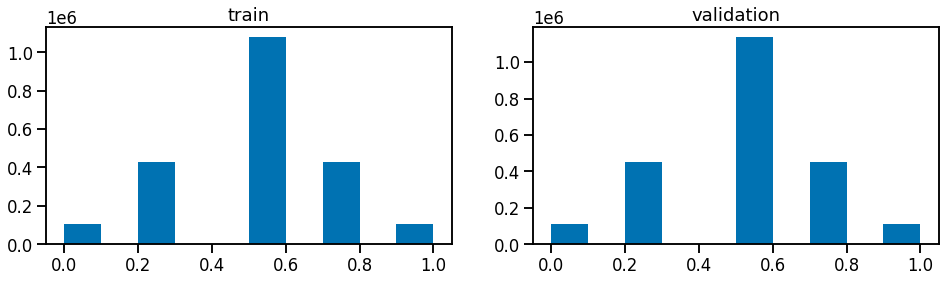

In [21]:
# there are train and validation...
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
ax = ax.flatten()

for i, data_type in enumerate(['train', 'validation']):
    # slice
    targets_ = targets.query(f'data_type == "{data_type}"')
    logger.info('*' * 50)
    logger.info('{} target: {:,} numerai tickers , {:,} bloomberg tickers (friday_date: {} - {})'.format(
        data_type, 
        targets_['ticker'].nunique(),
        targets_['bloomberg_ticker'].nunique(),
        targets_['friday_date'].min(),
        targets_['friday_date'].max(),
    ))
    
    # plot target
#     ax[i].hist(targets_['target'])
    ax[i].hist(targets_['target_20d'])
    ax[i].set_title(f'{data_type}')

In [22]:
# target relations
d = pd.crosstab(
    targets['target_4d'],
    targets['target_20d']
)
d['sum'] = d.values.sum(axis=1)
for i, f in enumerate(d.columns):
    d[f] = d.apply(lambda row : 100*row[f]/row['sum'], axis=1)
d.drop(columns=['sum'], inplace=True)

print('target transition matrix (%)')
d.astype(int).style.background_gradient(cmap='viridis', axis=1)

target transition matrix (%)


target_20d,0.0,0.25,0.5,0.75,1.0
target_4d,,,,,
0.0,28,37,25,6,2
0.25,7,32,46,10,2
0.5,2,18,57,18,2
0.75,2,10,47,32,7
1.0,2,5,25,38,28


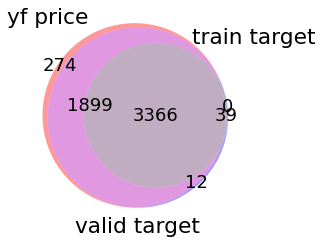

In [23]:
# ticker overlap
venn3(
    [
        set(df['ticker'].unique().tolist())
        , set(targets.query('data_type == "train"')['ticker'].unique().tolist())
        , set(targets.query('data_type == "validation"')['ticker'].unique().tolist())
    ],
    set_labels=('yf price', 'train target', 'valid target')
)

In [24]:
# select target-only tickers
df = df.loc[df['ticker'].isin(targets['ticker'])].reset_index(drop=True)

print('{:,} tickers: {:,} records'.format(df['ticker'].nunique(), len(df)))

5,266 tickers: 18,231,860 records


In [25]:
record_per_ticker = df.groupby('ticker')['date'].nunique().reset_index().sort_values(by='date')
record_per_ticker

,ticker,date
5169,WOLF,3
163,085370 KS,6
492,306040 KS,6
510,317330 KS,7
286,196170 KS,9
...,...,...
1549,ASELS TI,4869
2483,ENKAI TI,4869
1333,AGHOL TI,4869
3387,LOGO TI,4869


count    5266.000000
mean     3462.183821
std      1608.900392
min         3.000000
25%      1981.250000
50%      4624.500000
75%      4713.000000
max      4869.000000
Name: date, dtype: float64


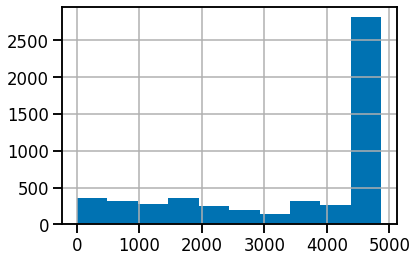

In [26]:
record_per_ticker['date'].hist()
print(record_per_ticker['date'].describe())

In [27]:
if CFG.DEBUG: # debug mode, using small set of data
    tickers_with_records = record_per_ticker.query('date >= 4830')['ticker'].values
else:
    tickers_with_records = record_per_ticker.query('date >= 1000')['ticker'].values
df = df.loc[df['ticker'].isin(tickers_with_records)].reset_index(drop=True)

print('Here, we use {:,} tickers: {:,} records'.format(df['ticker'].nunique(), len(df)))

Here, we use 4,570 tickers: 17,892,811 records


In [28]:
# first, fix date column in the yfiance stock data to be friday date (just naming along with numerai targets)
df['friday_date'] = df['date'].apply(lambda x : int(str(x).replace('-', '')))
df.tail(3)

,ticker,date,close,raw_close,high,low,open,volume,friday_date
17892808,ZZZ.,2021-10-06,32.750000,32.750000,33.500000,32.560001,33.340000,39175.0,20211006
17892809,ZZZ.,2021-10-07,33.500000,33.500000,33.709999,32.860001,32.860001,57200.0,20211007
17892810,ZZZ.,2021-10-08,33.389999,33.389999,34.070000,33.290001,33.290001,72400.0,20211008


In [29]:
# technical indicators
def RSI(close: pd.DataFrame, period: int = 14) -> pd.Series:
    # https://gist.github.com/jmoz/1f93b264650376131ed65875782df386
    """See source https://github.com/peerchemist/finta
    and fix https://www.tradingview.com/wiki/Talk:Relative_Strength_Index_(RSI)
    Relative Strength Index (RSI) is a momentum oscillator that measures the speed and change of price movements.
    RSI oscillates between zero and 100. Traditionally, and according to Wilder, RSI is considered overbought when above 70 and oversold when below 30.
    Signals can also be generated by looking for divergences, failure swings and centerline crossovers.
    RSI can also be used to identify the general trend."""

    delta = close.diff()

    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    _gain = up.ewm(com=(period - 1), min_periods=period).mean()
    _loss = down.abs().ewm(com=(period - 1), min_periods=period).mean()

    RS = _gain / _loss
    return pd.Series(100 - (100 / (1 + RS)))

def EMA1(x, n):
    """
    https://qiita.com/MuAuan/items/b08616a841be25d29817
    """
    a= 2/(n+1)
    return pd.Series(x).ewm(alpha=a).mean()

def MACD(close : pd.DataFrame, span1=12, span2=26, span3=9):
    """
    Compute MACD
    # https://www.learnpythonwithrune.org/pandas-calculate-the-moving-average-convergence-divergence-macd-for-a-stock/
    """
    exp1 = EMA1(close, span1)
    exp2 = EMA1(close, span2)
    macd = 100 * (exp1 - exp2) / exp2
    signal = EMA1(macd, span3)

    return macd, signal

def feature_engineering(ticker='ZEAL DC', df=df):
    """
    feature engineering
    
    :INPUTS:
    - ticker : numerai ticker name (str)
    - df : yfinance dataframe (pd.DataFrame)
    
    :OUTPUTS:
    - feature_df : feature engineered dataframe (pd.DataFrame)
    """
    # init
    keys = ['friday_date', 'ticker']
    feature_df = df.query(f'ticker == "{ticker}"')
    
    # price features
    new_feats = []
    for i, f in enumerate(['close', ]):
        for x in [20, 40, 60, ]:
            # return
            feature_df[f"{f}_return_{x}days"] = feature_df[
                f
            ].pct_change(x)

            # volatility
            feature_df[f"{f}_volatility_{x}days"] = (
                np.log1p(feature_df[f])
                .pct_change()
                .rolling(x)
                .std()
            )
        
            # kairi mean
            feature_df[f"{f}_MA_gap_{x}days"] = feature_df[f] / (
                feature_df[f].rolling(x).mean()
            )
            
            # features to use
            new_feats += [
                f"{f}_return_{x}days", 
                f"{f}_volatility_{x}days",
                f"{f}_MA_gap_{x}days",
                         ]

    # RSI
    feature_df['RSI'] = RSI(feature_df['close'], 14)

    # MACD
    macd, macd_signal = MACD(feature_df['close'], 12, 26, 9) 
    feature_df['MACD'] = macd
    feature_df['MACD_signal'] = macd_signal

    new_feats += ['RSI', 'MACD', 'MACD_signal']

    # only new feats
    feature_df = feature_df[new_feats + keys]

    # fill nan
    feature_df.fillna(method='ffill', inplace=True) # safe fillna method for a forecasting task
    feature_df.fillna(method='bfill', inplace=True) # just in case ... making sure no nan

    return feature_df

def add_features(df):
    # FE with multiprocessing
    tickers = df['ticker'].unique().tolist()
    print('FE for {:,} stocks...using {:,} CPUs...'.format(len(tickers), cpu_count()))
    start_time = time.time()
    with Pool(cpu_count()) as p:
        feature_dfs = list(tqdm(p.imap(feature_engineering, tickers), total=len(tickers)))
    return pd.concat(feature_dfs)

In [30]:
%%time

feature_df = add_features(df)
del df
gc.collect()

FE for 4,570 stocks...using 8 CPUs...


  0%|          | 0/4570 [00:00<?, ?it/s]

CPU times: user 16.2 s, sys: 7.35 s, total: 23.5 s
Wall time: 5min 15s


In [31]:
print(feature_df.shape)
feature_df.head()

(17892811, 14)


,close_return_20days,close_volatility_20days,close_MA_gap_20days,close_return_40days,close_volatility_40days,close_MA_gap_40days,close_return_60days,close_volatility_60days,close_MA_gap_60days,RSI,MACD,MACD_signal,friday_date,ticker
0,-0.165563,0.00369,0.947867,-0.278146,0.004524,0.772201,-0.15894,0.004719,1.025543,29.806907,0.000000,0.000000,20021202,000060 KS
1,-0.165563,0.00369,0.947867,-0.278146,0.004524,0.772201,-0.15894,0.004719,1.025543,29.806907,0.044120,0.024511,20021203,000060 KS
2,-0.165563,0.00369,0.947867,-0.278146,0.004524,0.772201,-0.15894,0.004719,1.025543,29.806907,-0.139534,-0.042721,20021204,000060 KS
3,-0.165563,0.00369,0.947867,-0.278146,0.004524,0.772201,-0.15894,0.004719,1.025543,29.806907,-0.246999,-0.111921,20021205,000060 KS
4,-0.165563,0.00369,0.947867,-0.278146,0.004524,0.772201,-0.15894,0.004719,1.025543,29.806907,-0.287639,-0.164193,20021206,000060 KS


In [32]:
feature_df.tail()

,close_return_20days,close_volatility_20days,close_MA_gap_20days,close_return_40days,close_volatility_40days,close_MA_gap_40days,close_return_60days,close_volatility_60days,close_MA_gap_60days,RSI,MACD,MACD_signal,friday_date,ticker
17892806,-0.048571,0.006228,0.949949,0.007869,0.005623,0.972920,0.177511,0.007763,1.025238,42.773694,0.823774,1.890156,20211004,ZZZ.
17892807,-0.031133,0.006253,0.960272,0.007494,0.005622,0.981798,0.149846,0.007683,1.032462,44.911797,0.493591,1.610843,20211005,ZZZ.
17892808,-0.056196,0.006427,0.938315,-0.033353,0.005691,0.957467,0.120808,0.007748,1.004228,40.402014,0.028886,1.294451,20211006,ZZZ.
17892809,-0.041762,0.006591,0.961815,-0.019608,0.005769,0.979873,0.172969,0.007726,1.024639,45.538131,-0.162804,1.003000,20211007,ZZZ.
17892810,-0.047904,0.006583,0.960974,-0.013298,0.005756,0.976977,0.174877,0.007724,1.018694,44.926591,-0.337421,0.734916,20211008,ZZZ.


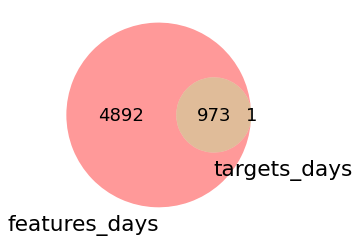

In [33]:
# do we have enough overlap with respect to 'friday_date'?
venn2([
    set(feature_df['friday_date'].astype(str).unique().tolist())
    , set(targets['friday_date'].astype(str).unique().tolist())
], set_labels=('features_days', 'targets_days'))

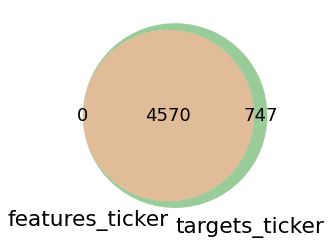

In [34]:
# do we have enough overlap with respect to 'ticker'?
venn2([
    set(feature_df['ticker'].astype(str).unique().tolist())
    , set(targets['ticker'].astype(str).unique().tolist())
], set_labels=('features_ticker', 'targets_ticker'))

In [35]:
# merge
feature_df['friday_date'] = feature_df['friday_date'].astype(int)
targets['friday_date'] = targets['friday_date'].astype(int)

feature_df = feature_df.merge(
    targets,
    how='left',
    on=['friday_date', 'ticker']
)

print(feature_df.shape)
feature_df.tail()

(17892811, 18)


,close_return_20days,close_volatility_20days,close_MA_gap_20days,close_return_40days,close_volatility_40days,close_MA_gap_40days,close_return_60days,close_volatility_60days,close_MA_gap_60days,RSI,MACD,MACD_signal,friday_date,ticker,bloomberg_ticker,data_type,target_4d,target_20d
17892806,-0.048571,0.006228,0.949949,0.007869,0.005623,0.972920,0.177511,0.007763,1.025238,42.773694,0.823774,1.890156,20211004,ZZZ.,NaN,NaN,NaN,NaN
17892807,-0.031133,0.006253,0.960272,0.007494,0.005622,0.981798,0.149846,0.007683,1.032462,44.911797,0.493591,1.610843,20211005,ZZZ.,NaN,NaN,NaN,NaN
17892808,-0.056196,0.006427,0.938315,-0.033353,0.005691,0.957467,0.120808,0.007748,1.004228,40.402014,0.028886,1.294451,20211006,ZZZ.,NaN,NaN,NaN,NaN
17892809,-0.041762,0.006591,0.961815,-0.019608,0.005769,0.979873,0.172969,0.007726,1.024639,45.538131,-0.162804,1.003000,20211007,ZZZ.,NaN,NaN,NaN,NaN
17892810,-0.047904,0.006583,0.960974,-0.013298,0.005756,0.976977,0.174877,0.007724,1.018694,44.926591,-0.337421,0.734916,20211008,ZZZ.,NaN,NaN,NaN,NaN


In [36]:
# save (just to make sure that we are on the safe side if yfinance is dead some day...)
# feature_df.to_pickle(f'{CFG.OUTPUT_DIR}/feature_df.pkl')
feature_df.to_pickle(f'feature_df.pkl')
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17892811 entries, 0 to 17892810
Data columns (total 18 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   close_return_20days      float64
 1   close_volatility_20days  float64
 2   close_MA_gap_20days      float64
 3   close_return_40days      float64
 4   close_volatility_40days  float64
 5   close_MA_gap_40days      float64
 6   close_return_60days      float64
 7   close_volatility_60days  float64
 8   close_MA_gap_60days      float64
 9   RSI                      float64
 10  MACD                     float64
 11  MACD_signal              float64
 12  friday_date              int64  
 13  ticker                   object 
 14  bloomberg_ticker         object 
 15  data_type                object 
 16  target_4d                float64
 17  target_20d               float64
dtypes: float64(14), int64(1), object(3)
memory usage: 2.5+ GB


In [37]:
target = 'target_20d'
if 'target_20d' not in feature_df.columns.values.tolist():
    print('No target 20d exists...using target_4d instead...')
    target = 'target'
drops = ['data_type', 'target_4d', 'target_20d', 'friday_date', 'ticker', 'bloomberg_ticker']
features = [f for f in feature_df.columns.values.tolist() if f not in drops]

logger.info('{:,} features: {}'.format(len(features), features))

12 features: ['close_return_20days', 'close_volatility_20days', 'close_MA_gap_20days', 'close_return_40days', 'close_volatility_40days', 'close_MA_gap_40days', 'close_return_60days', 'close_volatility_60days', 'close_MA_gap_60days', 'RSI', 'MACD', 'MACD_signal']
2021-10-10 09:37:51,514 INFO __main__: 12 features: ['close_return_20days', 'close_volatility_20days', 'close_MA_gap_20days', 'close_return_40days', 'close_volatility_40days', 'close_MA_gap_40days', 'close_return_60days', 'close_volatility_60days', 'close_MA_gap_60days', 'RSI', 'MACD', 'MACD_signal']


In [38]:
# train-valid split
train_set = {
    'X': feature_df.query('data_type == "train"')[features], 
    'y': feature_df.query('data_type == "train"')[target].astype(np.float64)
}
val_df = feature_df.query('data_type == "validation"').dropna().copy()
val_set = {
    'X': val_df[features], 
    'y': val_df[target].astype(np.float64)
}

assert train_set['y'].isna().sum() == 0
assert val_set['y'].isna().sum() == 0

In [39]:
# same parameters of the Integration-Test
import joblib
from sklearn import utils
import xgboost as xgb
import operator

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'colsample_bytree': 0.1,                 
    'learning_rate': 0.01,
    'max_depth': 5,
    'seed': 46,
    'n_estimators': 2000,
#     'tree_method': 'gpu_hist' # if you want to use GPU ...
}

# define 
model = xgb.XGBRegressor(**params)

# fit
model.fit(
    train_set['X'], train_set['y'], 
    eval_set=[(val_set['X'], val_set['y'])],
    verbose=100, 
    early_stopping_rounds=100,
)

# save model
# joblib.dump(model, f'{CFG.OUTPUT_DIR}/xgb_model_val.pkl')
joblib.dump(model, f'xgb_model_val.pkl')
logger.info('xgb model with early stopping saved!')

# feature importance
importance = model.get_booster().get_score(importance_type='gain')
importance = sorted(importance.items(), key=operator.itemgetter(1))
feature_importance_df = pd.DataFrame(importance, columns=['features', 'importance'])

[0]	validation_0-rmse:0.213404
Will train until validation_0-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:0.213363
[200]	validation_0-rmse:0.213358
Stopping. Best iteration:
[172]	validation_0-rmse:0.213358



xgb model with early stopping saved!
2021-10-10 09:40:18,178 INFO __main__: xgb model with early stopping saved!


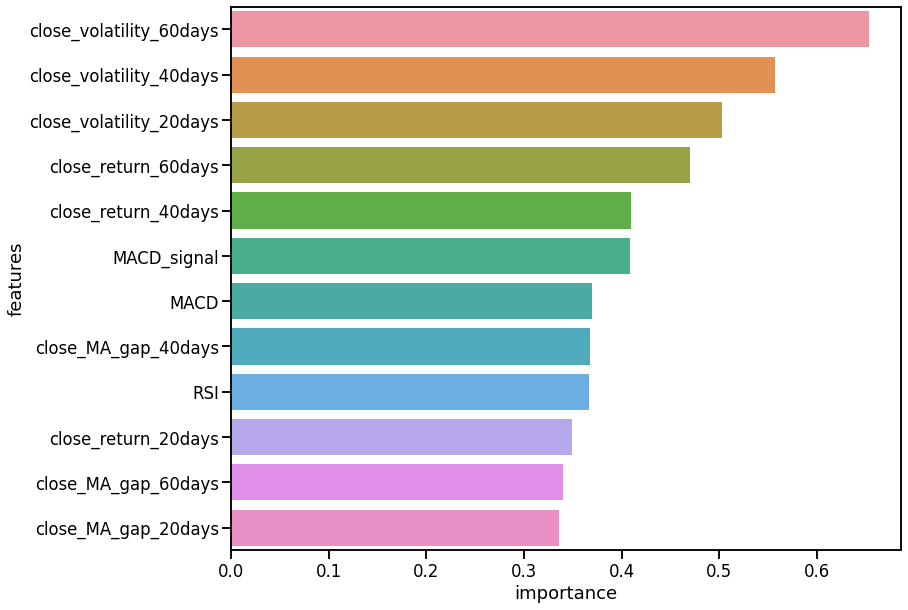

In [40]:
# feature importance
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.barplot(
    x='importance', 
    y='features', 
    data=feature_importance_df.sort_values(by='importance', ascending=False),
    ax=ax
)

In [41]:
# https://colab.research.google.com/drive/1ECh69C0LDCUnuyvEmNFZ51l_276nkQqo#scrollTo=tTBUzPep2dm3

def score(df, target_name=target, pred_name='prediction'):
    '''Takes df and calculates spearm correlation from pre-defined cols'''
    # method="first" breaks ties based on order in array
    return np.corrcoef(
        df[target_name],
        df[pred_name].rank(pct=True, method="first")
    )[0,1]

def run_analytics(era_scores):
    print(f"Mean Correlation: {era_scores.mean():.4f}")
    print(f"Median Correlation: {era_scores.median():.4f}")
    print(f"Standard Deviation: {era_scores.std():.4f}")
    print('\n')
    print(f"Mean Pseudo-Sharpe: {era_scores.mean()/era_scores.std():.4f}")
    print(f"Median Pseudo-Sharpe: {era_scores.median()/era_scores.std():.4f}")
    print('\n')
    print(f'Hit Rate (% positive eras): {era_scores.apply(lambda x: np.sign(x)).value_counts()[1]/len(era_scores):.2%}')

    era_scores.rolling(10).mean().plot(kind='line', title='Rolling Per Era Correlation Mean', figsize=(15,4))
    plt.axhline(y=0.0, color="r", linestyle="--"); plt.show()

    era_scores.cumsum().plot(title='Cumulative Sum of Era Scores', figsize=(15,4))
    plt.axhline(y=0.0, color="r", linestyle="--"); plt.show()

Mean Correlation: 0.0141
Median Correlation: 0.0129
Standard Deviation: 0.0243


Mean Pseudo-Sharpe: 0.5795
Median Pseudo-Sharpe: 0.5308


Hit Rate (% positive eras): 78.94%


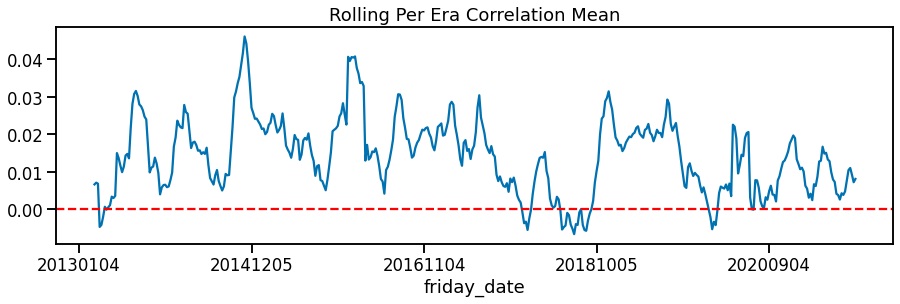

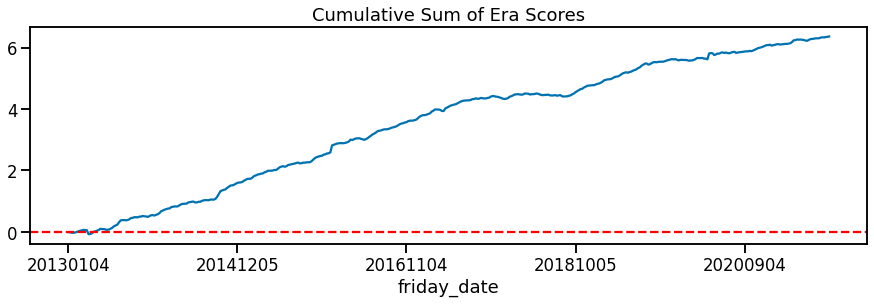

In [42]:
# prediction for the validation set
valid_sub = val_df[drops].copy()
valid_sub['prediction'] = model.predict(val_set['X'])

# compute score
val_era_scores = valid_sub.copy()
val_era_scores['friday_date'] = val_era_scores['friday_date'].astype(str)
val_era_scores = val_era_scores.loc[val_era_scores['prediction'].isna() == False].groupby(['friday_date']).apply(score)
run_analytics(val_era_scores)

In [43]:
# recent friday date?
recent_friday = datetime.now() + relativedelta(weekday=FR(-1))
recent_friday = int(recent_friday.strftime('%Y%m%d'))
print(f'Most recent Friday: {recent_friday}')

Most recent Friday: 20211008


In [44]:
# in case no recent friday is available...prep the second last
recent_friday2 = datetime.now() + relativedelta(weekday=FR(-2))
recent_friday2 = int(recent_friday2.strftime('%Y%m%d'))
print(f'Second most recent Friday: {recent_friday2}')

Second most recent Friday: 20211001


In [45]:
# do we have at least 5 tickers, whose the latest date matches the recent friday?
ticker_date_df = feature_df.groupby('ticker')['friday_date'].max().reset_index()
if len(ticker_date_df.loc[ticker_date_df['friday_date'] == recent_friday]) >= 5:
    ticker_date_df = ticker_date_df.loc[ticker_date_df['friday_date'] == recent_friday]
else: # use dates later than the second last friday
    ticker_date_df = ticker_date_df.loc[ticker_date_df['friday_date'] == recent_friday2]
    recent_friday = recent_friday2
    
print(len(ticker_date_df))
ticker_date_df

4520


,ticker,friday_date
0,000060 KS,20211008
1,000080 KS,20211008
2,000100 KS,20211008
3,000120 KS,20211008
4,000210 KS,20211008
...,...,...
4565,ZTS,20211008
4566,ZUMZ,20211008
4567,ZURN SW,20211008
4568,ZYXI,20211008


In [46]:
# live sub
feature_df.loc[feature_df['friday_date'] == recent_friday, 'data_type'] = 'live'
test_sub = feature_df.query('data_type == "live"')[drops].copy()
test_sub['prediction'] = model.predict(feature_df.query('data_type == "live"')[features])

logger.info(test_sub.shape)
test_sub.head()

(4520, 7)
2021-10-10 09:40:35,915 INFO __main__: (4520, 7)


,data_type,target_4d,target_20d,friday_date,ticker,bloomberg_ticker,prediction
4678,live,NaN,NaN,20211008,000060 KS,NaN,0.504216
7635,live,NaN,NaN,20211008,000080 KS,NaN,0.502587
12340,live,NaN,NaN,20211008,000100 KS,NaN,0.503399
17015,live,NaN,NaN,20211008,000120 KS,NaN,0.505690
21719,live,NaN,NaN,20211008,000210 KS,NaN,0.504409


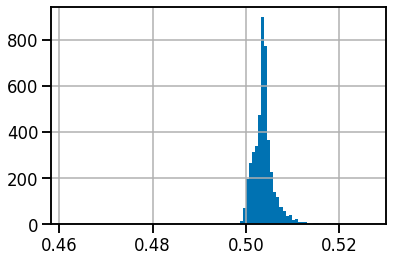

In [47]:
# histogram of prediction
test_sub['prediction'].hist(bins=100)

In [48]:
# To submit, you need to have Numerai account and have API's id and secret key. Also you need to have at least one (numerai signals') model slot.
def submit_signal(sub: pd.DataFrame, public_id: str, secret_key: str, slot_name: str):
    """
    submit numerai signals prediction
    """
    # setup private API
    napi = numerapi.SignalsAPI(public_id, secret_key)
    
    # write predictions to csv
    model_id = napi.get_models()[f'{slot_name}']
    filename = f"sub_{model_id}.csv"
    sub.to_csv(filename, index=False)
    
    # submit
    submission = napi.upload_predictions(filename, model_id=model_id)
    print(f'Submitted : {slot_name}!')
    
# concat valid and test 
sub = pd.concat([valid_sub, test_sub], ignore_index=True)

# rename to 'signal'
sub.rename(columns={'prediction': 'signal'}, inplace=True)

# select necessary columns
sub = sub[['ticker', 'friday_date', 'data_type', 'signal']]

# save 
# sub.to_csv(f'{CFG.OUTPUT_DIR}/example_submission_{today}.csv', index=False)
sub.to_csv(f'submission_{today}.csv', index=False)

In [49]:
public_id = 'B4LKKVAJ5Q7ABMV3EFGLSFMSNX4G5DVT'
secret_key = 'KNW2CKHBAOWACT65UINT7FITY73OLUCV6IXCZYHZ6FII5AEH6X3FNW7VIKVGKE7I'
model_id = 'eaa5d55b-5d9e-4cef-9084-3f29bdaf9309'
# submit_signal(sub, public_id, secret_key, slot_name) # uncomment if you submit
napi = numerapi.SignalsAPI(public_id=public_id, secret_key=secret_key)
#napi.upload_predictions(f'{CFG.OUTPUT_DIR}/example_submission_{today}.csv', model_id=model_id)
napi.upload_predictions(f'submission_{today}.csv', model_id=model_id)

2021-10-10 09:40:40,180 INFO numerapi.base_api: uploading predictions...


'6f5cd164-54c4-4b79-ac4b-8f32f774a8a5'

In [50]:
sub.head()

,ticker,friday_date,data_type,signal
0,000060 KS,20130104,validation,0.503752
1,000060 KS,20130111,validation,0.502219
2,000060 KS,20130118,validation,0.499558
3,000060 KS,20130125,validation,0.501343
4,000060 KS,20130201,validation,0.502996


In [51]:
sub.tail()

,ticker,friday_date,data_type,signal
1547127,ZTS,20211008,live,0.504581
1547128,ZUMZ,20211008,live,0.503609
1547129,ZURN SW,20211008,live,0.503287
1547130,ZYXI,20211008,live,0.508572
1547131,ZZZ.,20211008,live,0.503909
